# CAPSTONE PROJECT:
[eCommerce] – How Show Recommendations In Netflix Affects User Churn Rate 

## Step 2: Data Collection & Understanding

In [ ]:
# Dataset was from Kaggle. Source is in the final paper. 

import pandas as pd

df = pd.read_csv("/netflix_customer_churn.csv")
df.info()
df.describe()


## Step 3: Data Preprocessing, Applied EDA & Feature Engineering

In [4]:
#3.1 Data Cleaning (Reproducible)

import numpy as np

# Handle missing values
df['age'] = df['age'].fillna(df['age'].median())
df['gender'] = df['gender'].fillna(df['gender'].mode()[0])

# Remove duplicates
df.drop_duplicates(inplace=True)

# Outlier treatment (IQR capping)
# Corrected column names based on df.info()
for col in ['watch_hours', 'last_login_days']:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    df[col] = np.clip(df[col], q1 - 1.5*iqr, q3 + 1.5*iqr)

<Axes: >

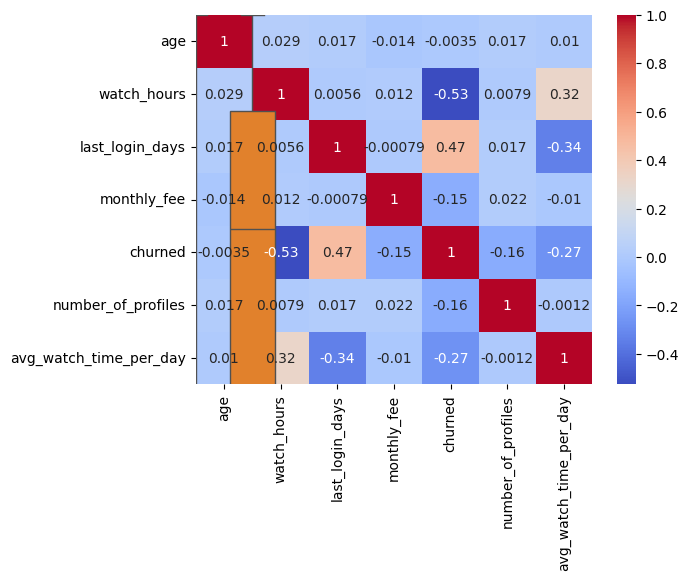

In [5]:
#3.2 Applied EDA (Key Insights)
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(df['watch_hours'], kde=True)
sns.boxplot(x='churned', y='watch_hours', data=df)
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')

In [ ]:
#3.3 Feature Engineering (Domain Knowledge)
# Engagement_intensity added to help capture churn
# Formula uses watch_hours and last_login_days

# Heavy_user added to determine who often use the application
# Formula uses watch_hours

# Low_engagement added to determine who seldom use the app 
# Formula uses watch_hours and last_login_days

# Engagement-based feature engineering (CSV-safe)

df['engagement_intensity'] = (
    df['watch_hours'] / (df['last_login_days'] + 1)
)

df['heavy_user'] = (
    df['watch_hours'] > df['watch_hours'].median()
).astype(int)

df['low_engagement'] = (
    (df['watch_hours'] < df['watch_hours'].quantile(0.25)) &
    (df['last_login_days'] < df['last_login_days'].quantile(0.25))
).astype(int)

In [ ]:
#3.4 Encoding, Scaling & Feature Selection

from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['churned', 'customer_id'])
y = df['churned']

X = pd.get_dummies(X, drop_first=True)

scaler = StandardScaler()
num_cols = X.select_dtypes(include='number').columns
X[num_cols] = scaler.fit_transform(X[num_cols])

#Feature Selection (Embedded – Random Forest)

from sklearn.ensemble import RandomForestClassifier

rf_temp = RandomForestClassifier(random_state=42)
rf_temp.fit(X, y)

importances = pd.Series(rf_temp.feature_importances_, index=X.columns)
selected_features = importances[importances > importances.mean()].index
X = X[selected_features]

In [ ]:
#3.5 Dimensionality Reduction (PCA)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

## Step 4: Model Implementation

In [ ]:
#4.1 Train/Test Split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
#4.2 Models Trained

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Random Forest": RandomForestClassifier(n_estimators=300)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_test)[:,1]
    results[name] = roc_auc_score(y_test, preds)

results

{'Logistic Regression': np.float64(0.9456940449856195),
 'Decision Tree': np.float64(0.9643107151857466),
 'Random Forest': np.float64(0.9718489865635165)}

In [ ]:
#4.3 Hyperparameter Tuning

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [5, 10, None]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring='roc_auc',
    cv=5
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

import joblib

In [ ]:
#4.4 Saving the Model

joblib.dump(best_model, "netflix_churn_model.pkl")
joblib.dump(scaler, "scaler.pkl")

#4.5 Loading the Model (for Deployment / Reuse)

loaded_model = joblib.load("netflix_churn_model.pkl")
loaded_scaler = joblib.load("scaler.pkl")

## Step 5: Critical Thinking → Ethical AI & Bias Auditing

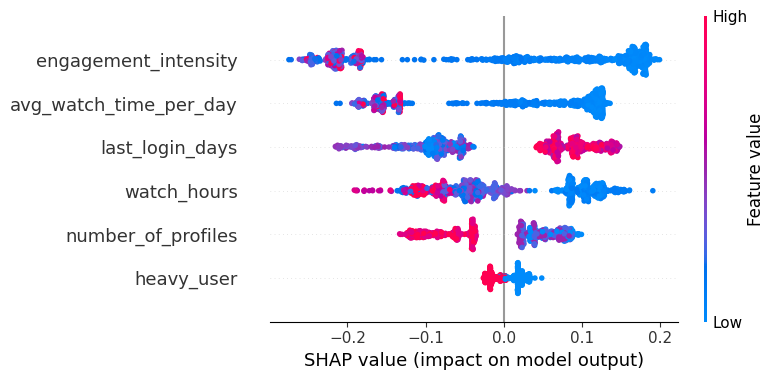

In [13]:
#5.1 Explainability (SHAP)

import shap

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[:, :, 1], X_test)

In [ ]:
#5.2 Sensitive Attributes Audited

df['age_group'] = pd.cut(
    df['age'],
    bins=[0, 25, 40, 60, 100],
    labels=['Youth', 'Adult', 'Middle-aged', 'Senior']
)

#5.3 Prediction Outputs for Fairness Evaluation

y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

results_df = X_test.copy()
results_df['true_churn'] = y_test.values
results_df['pred_churn'] = y_test_pred

In [ ]:
#5.4 Bias & Fairness Audit

def group_churn(df, group):
    return df.groupby(group)['churned'].mean()

group_churn(df, 'gender')
group_churn(df, 'subscription_type')

,churned
subscription_type,
Basic,0.618302
Premium,0.437094
Standard,0.454435


In [17]:
#5.5 Fairness Metric 1: Demographic Parity

def demographic_parity(df, group_col):
    return df.groupby(group_col)['pred_churn'].mean()

demographic_parity(results_df.join(df[['gender']]), 'gender')
demographic_parity(results_df.join(df[['age_group']]), 'age_group')


/tmp/ipython-input-4002509200.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(group_col)['pred_churn'].mean()


,pred_churn
age_group,
Youth,0.532374
Adult,0.560403
Middle-aged,0.509859
Senior,0.557692


In [21]:
#5.6 Fairness Metric 2: Disparate Impact

def disparate_impact(df, group_col, protected, reference):
    p_protected = df[df[group_col] == protected]['pred_churn'].mean()
    p_reference = df[df[group_col] == reference]['pred_churn'].mean()
    return p_protected / p_reference

disparate_impact(
    results_df.join(df[['gender']]),
    'gender',
    protected='Female',
    reference='Male'
)

np.float64(1.0586027344748274)

In [22]:
#5.7 Fairness Metric 3: Equalised Odds

from sklearn.metrics import confusion_matrix

def equalized_odds(df, group_col):
    metrics = {}
    for group in df[group_col].unique():
        subset = df[df[group_col] == group]
        tn, fp, fn, tp = confusion_matrix(
            subset['true_churn'],
            subset['pred_churn']
        ).ravel()
        metrics[group] = {
            'TPR': tp / (tp + fn),
            'FPR': fp / (fp + tn)
        }
    return metrics

equalized_odds(results_df.join(df[['gender']]), 'gender')

{'Male': {'TPR': np.float64(0.9349112426035503),
  'FPR': np.float64(0.1348314606741573)},
 'Female': {'TPR': np.float64(0.9672131147540983),
  'FPR': np.float64(0.08695652173913043)},
 'Other': {'TPR': np.float64(0.9271523178807947),
  'FPR': np.float64(0.15822784810126583)}}